# Price prediction

Análise exploratória, modelagem e avaliação com dados do Kaggle.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## Carregamento e visualização inicial dos dados

In [14]:
df = pd.read_csv("../data/train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [16]:
df = df.drop(columns=["Alley", "PoolQC", "Fence", "MiscFeature"], errors='ignore')
df = df.dropna()
df = pd.get_dummies(df, columns=["Neighborhood"], drop_first=True)

## Visualização da distribuição dos preços

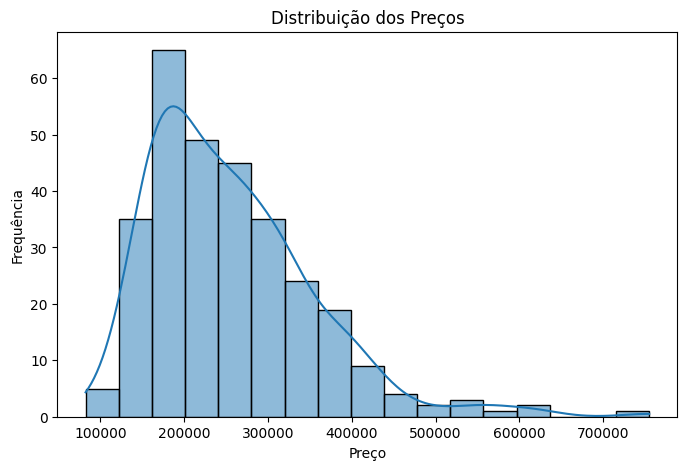

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df['SalePrice'], kde=True)
plt.title("Distribuição dos Preços")
plt.xlabel("Preço")
plt.ylabel("Frequência")
plt.show()

## Correlação com a variável alvo

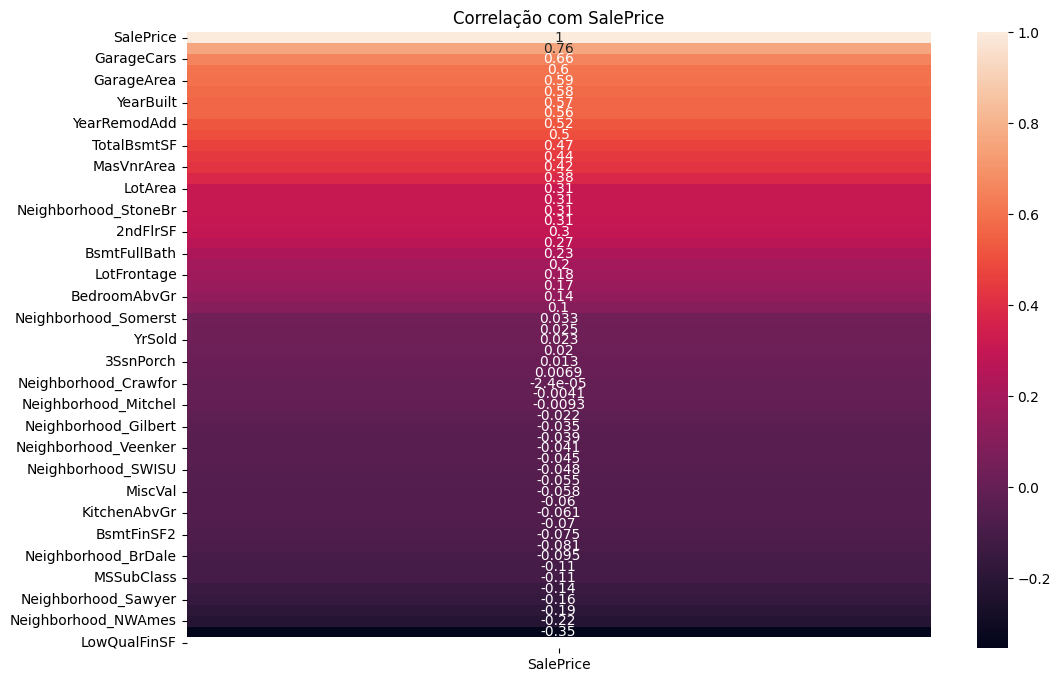

In [18]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True)
plt.title("Correlação com SalePrice")
plt.show()

## Seleção de variáveis e preparação para modelagem

In [19]:
bairros = [col for col in df.columns if col.startswith("Neighborhood_")]
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
            'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'] + bairros
df_model = df[features + ['SalePrice']]
X = df_model.drop('SalePrice', axis=1)
y = df_model['SalePrice']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelo 1: Regressão Linear

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("R²:", r2_score(y_test, y_pred_lr))
print("RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))

R²: 0.751767693474316
RMSE: 52604.31591307754


In [22]:
X_train_sm = sm.add_constant(X_train)
X_train_sm = X_train_sm.astype(float)
ols_model = sm.OLS(y_train, X_train_sm).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     23.87
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           2.78e-49
Time:                        16:12:43   Log-Likelihood:                -2915.8
No. Observations:                 239   AIC:                             5886.
Df Residuals:                     212   BIC:                             5979.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   1.6e+06   1.14e+06      1.401      0.163   -6.51e+05    3.85e+06
OverallQual           2.768e+04   5450.805      5.079      0.000    1.69e+04    3.84e+04
GrLivArea                9.4214     14.301      0.659      0.511     -18.769      37.612
GarageCars             3.59e+04   1.15e+04      3.118      0.002    1.32e+04    5.86e+04
GarageArea             -38.3018     35.810     -1.070      0.286    -108.891      32.287
TotalBsmtSF            -24.5413     22.514     -1.090      0.277     -68.921      19.838
1stFlrSF                49.1780     26.000      1.891      0.060      -2.074     100.430
FullBath              3592.4354   1.04e+04      0.346      0.730   -1.69e+04    2.41e+04
TotRmsAbvGrd          1.113e+04   4310.262      2.583      0.010    2635.711    1.96e+04
YearBuilt             -898.1214    578.298     -1.553      0.122   -2038.072     241.829
Neighborhood_BrDale  -5753.6517   5.77e+04     -0.100      0.921    -1.2e+05    1.08e+05
Neighborhood_ClearCr  5845.5074   4.25e+04      0.137      0.891    -7.8e+04    8.97e+04
Neighborhood_CollgCr  4.443e+04   2.07e+04      2.148      0.033    3658.605    8.52e+04
Neighborhood_Crawfor  8.082e+04   3.09e+04      2.614      0.010    1.99e+04    1.42e+05
Neighborhood_Edwards -4.017e+04   2.94e+04     -1.365      0.174   -9.82e+04    1.78e+04
Neighborhood_Gilbert  3.096e+04   2.65e+04      1.168      0.244   -2.13e+04    8.32e+04
Neighborhood_Mitchel  1.306e-09   8.18e-09      0.160      0.873   -1.48e-08    1.74e-08
Neighborhood_NAmes    -1.12e+04      3e+04     -0.374      0.709   -7.03e+04    4.79e+04
Neighborhood_NWAmes  -1.031e+04   2.52e+04     -0.408      0.683      -6e+04    3.94e+04
Neighborhood_NoRidge  7.592e+04   2.42e+04      3.132      0.002    2.81e+04    1.24e+05
Neighborhood_NridgHt   7.21e+04   1.93e+04      3.730      0.000     3.4e+04     1.1e+05
Neighborhood_OldTown  2.041e+04   6.34e+04      0.322      0.748   -1.05e+05    1.45e+05
Neighborhood_SWISU    2.113e+04   6.43e+04      0.329      0.743   -1.06e+05    1.48e+05
Neighborhood_Sawyer   -1.62e+04   3.55e+04     -0.457      0.648   -8.61e+04    5.37e+04
Neighborhood_SawyerW   2.03e+04   2.51e+04      0.809      0.419   -2.91e+04    6.97e+04
Neighborhood_Somerst  3.751e+04   2.15e+04      1.745      0.082   -4861.836    7.99e+04
Neighborhood_StoneBr  1.224e+05   2.45e+04      4.996      0.000    7.41e+04    1.71e+05
Neighborhood_Timber   3.221e+04   2.16e+04      1.489      0.138   -1.04e+04    7.49e+04
Neighborhood_Veenker          0          0        nan        nan           0           0
==============================================================================
Omnibus:                       80.538   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              604.87

## Modelo 2: Árvore de Regressão

In [23]:
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("R²:", r2_score(y_test, y_pred_dt))
print("RMSE:", mean_squared_error(y_test, y_pred_dt, squared=False))

R²: 0.7668036061799615
RMSE: 50986.25820211016


## Comparação visual

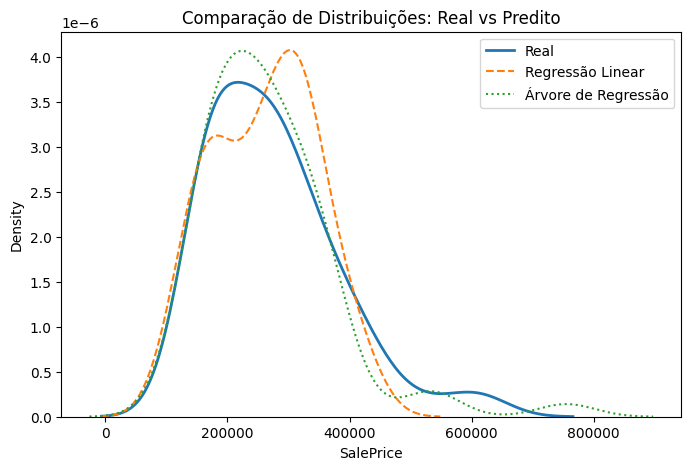

In [24]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test, label='Real', linewidth=2)
sns.kdeplot(y_pred_lr, label='Regressão Linear', linestyle="--")
sns.kdeplot(y_pred_dt, label='Árvore de Regressão', linestyle=":")
plt.title("Comparação de Distribuições: Real vs Predito")
plt.legend()
plt.show()